In [443]:
from monai.apps import DecathlonDataset
from monai.data import DataLoader
import os
from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    Compose,
    OrientationD,
)
import random
import matplotlib.pyplot as plt
import torch
import pickle as pkl
import numpy as np
import pandas as pd

In [31]:
# random.seed(0)

In [249]:
crt_dir = os.getcwd()
datasets_path = f'{crt_dir}/datasets/MSD/MedicalDecathlon/'
datasets_path

'/home/aimas/Desktop/Disertatie_CataChiru/LungCancerCT/datasets/MSD/MedicalDecathlon/'

In [250]:
base_transform = Compose([
    LoadImageD(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    OrientationD(keys=["image", "label"], axcodes='RAS'),
])

In [14]:
train_dataset = DecathlonDataset(root_dir = datasets_path,
                        task = "Task06_Lung", section = "training",
                        transform = base_transform, download = False)

Loading dataset: 100%|██████████████████████████| 51/51 [04:04<00:00,  4.80s/it]


In [411]:
len(train_dataset)

51

In [412]:
rand_idx = [ ]

for i in range(11):
    next_idx = random.randint(0, len(train_dataset) - 1)
    if next_idx in rand_idx:
        i -= 1
    rand_idx.append(next_idx)

rand_idx

[33, 12, 13, 31, 5, 12, 6, 32, 8, 38, 12]

In [413]:
rand_train = []

for idx in rand_idx:
    rand_train.append(train_dataset[idx])
    


In [49]:
rand_train[0]['label'].shape

torch.Size([1, 512, 512, 251])

In [89]:
last_dim = rand_train[1]['label'].shape[-1]
last_dim

266

In [414]:
def get_first_tumorous_slice(patient):
    last_dim = patient.shape[-1]
        
    for i in range(last_dim):
        mask = patient[0,..., i].sum()
        if mask > 0:
            return i
    
    raise Exception("Patient does not have tumorous slices") 
    
    
def get_last_tumorous_slice(patient):
    last_dim = patient.shape[-1]
        
    for i in range(last_dim):
        mask = patient[0,..., last_dim - i - 1].sum()
        if mask > 0:
            return last_dim - i - 1
    
    raise Exception("Patient does not have tumorous slices") 


In [221]:
tumor_start = get_first_tumorous_slice(rand_train[1]['label'])
        
tumor_start

299

In [224]:
tumor_end = get_last_tumorous_slice(rand_train[1]['label'])
        
tumor_end

333

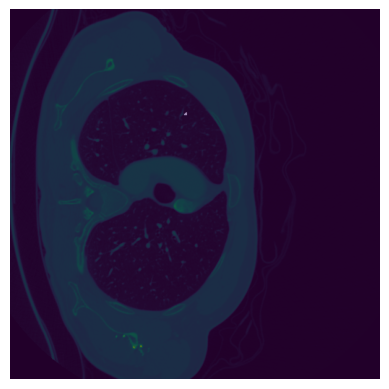

In [225]:
show_idx = tumor_start
plt.imshow(rand_train[1]['image'][0, ..., show_idx])
plt.imshow(rand_train[1]['label'][0, ..., show_idx], cmap='gray', alpha=0.5)
plt.axis('off')
plt.show()

In [415]:
def aggregate_heatmap(dataset):
    sample_stack = torch.zeros_like(dataset[0]['label'][0, ..., 1])     
#     print(sample_stack.shape)
    sample_stack = sample_stack.unsqueeze(0)
    
    for i in range(len(dataset)):
        sample_stack += dataset[i]['label'].sum(dim=3)
        
    sample_stack = sample_stack.squeeze(0)
    
    return sample_stack


def aggregate_heatmap_average(dataset):
    avg_slice_idx = []
    no_tumor_slices = 0
    
    for sample in range(len(dataset)):
        tumor_start = get_first_tumorous_slice(dataset[sample]['label'])
        tumor_end = get_last_tumorous_slice(dataset[sample]['label'])

        no_tumor_slices += int(tumor_end - tumor_start + 1)
    
    sample_stack = aggregate_heatmap(dataset)
    sample_stack /= no_tumor_slices
    
    return sample_stack

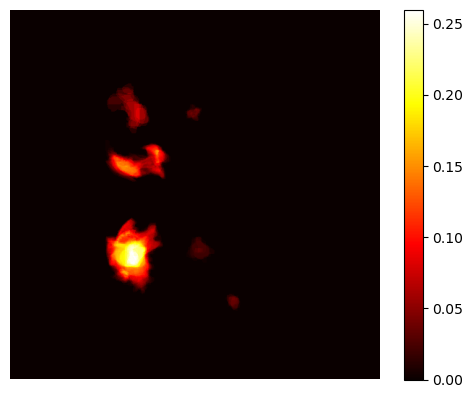

In [416]:
dev_heatmap = aggregate_heatmap_average(rand_train)

plt.imshow(dev_heatmap, cmap='hot')
plt.axis('off')
plt.colorbar()
plt.show()

In [243]:
computational_effort_val_path = f'./msd_eda1_computational_effort_validation.pkl'

binning_volume_val, _, bins_2d_val, _, _, _ = pkl.load(open(computational_effort_val_path, 'rb'))

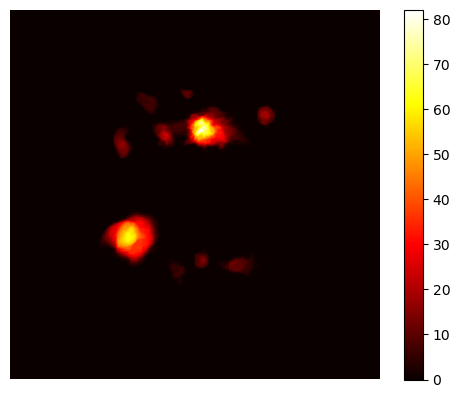

In [235]:
# heatmap = aggregate_heatmap(rand_train)

plt.imshow(bins_2d_val.sum(axis = 0), cmap='hot')
plt.axis('off')
plt.colorbar()
plt.show()

In [417]:
def rmse_dev_vs_val(dev_heatmap, val_heatmap):
    rmse = np.sqrt((np.square(dev_heatmap - val_heatmap))).mean()
    
    return rmse

In [418]:
rmse_dev_vs_val(dev_heatmap, bins_2d_val)

0.07762079462949245

In [419]:
def pick_best_samples(no_tries, no_samples= 11, method= "count"):
    min_rmse = torch.inf
    best_heatmap = None
    
    for tri in range(no_tries):
        rand_idx = [ ]

        for i in range(no_samples):
            rand_idx.append(random.randint(0, len(train_dataset) - 1))

        print(f'Indices taken out of train for dev: {rand_idx}')

        rand_train = []

        for idx in rand_idx:
            rand_train.append(train_dataset[idx])
        if method == "count":
            dev_heatmap = aggregate_heatmap(rand_train)
            
        if method == "average":
            dev_heatmap = aggregate_heatmap_average(rand_train)
        
        rmse = rmse_dev_vs_val(dev_heatmap, bins_2d_val)
        
        print(f'For current indices: RMSE  = {rmse:.3f}')
        
        if rmse < min_rmse:
            min_rmse = rmse
            best_heatmap = dev_heatmap
    
    return best_heatmap, min_rmse

Indices taken out of train for dev: [35, 36, 33, 40, 39, 27, 38, 25, 41, 16, 43]
For current indices: RMSE  = 1.765
Indices taken out of train for dev: [30, 40, 40, 38, 50, 1, 22, 22, 49, 50, 13]
For current indices: RMSE  = 0.566
Indices taken out of train for dev: [44, 41, 2, 12, 28, 13, 33, 43, 13, 0, 9]
For current indices: RMSE  = 1.292
Indices taken out of train for dev: [15, 29, 30, 5, 38, 17, 41, 18, 25, 21, 47]
For current indices: RMSE  = 1.748
Indices taken out of train for dev: [46, 42, 45, 19, 42, 5, 39, 7, 31, 23, 39]
For current indices: RMSE  = 2.589
Indices taken out of train for dev: [39, 41, 5, 14, 8, 26, 15, 1, 31, 18, 9]
For current indices: RMSE  = 1.147
Indices taken out of train for dev: [33, 40, 23, 47, 43, 9, 7, 32, 20, 20, 43]
For current indices: RMSE  = 2.160
Indices taken out of train for dev: [46, 4, 23, 12, 12, 18, 33, 44, 27, 41, 46]
For current indices: RMSE  = 1.158
Indices taken out of train for dev: [47, 24, 25, 2, 9, 28, 4, 18, 40, 42, 9]
For curre

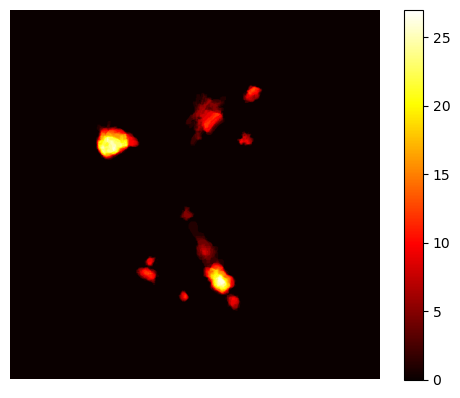

In [420]:
heatmap, rmse = pick_best_samples(50, method= "count")

print(rmse)

plt.imshow(heatmap, cmap='hot')
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
# Count
# Indices taken out of train for dev: [26, 24, 50, 41, 44, 48, 40, 49, 14, 18, 31]
# For current indices: RMSE  = 0.334

# Average
# Indices taken out of train for dev: [11, 34, 45, 45, 38, 7, 28, 30, 13, 44, 11]
# For current indices: RMSE  = 0.076
# Indices taken out of train for dev: [36, 9, 22, 23, 18, 40, 18, 20, 31, 50, 25]
# For current indices: RMSE  = 0.093

In [246]:
def get_binning_volume(train_data, no_bins= 10):
        # if np.sum(crt_stack) != 0:
#     idx = int(((j * 10) / label.shape[-1]))
#     binning_volume[i, idx] += 1

    all_start = []
    for j in range(len(train_data)):
        tumor_start = 0
        tumor_end = 0
        last_dim = train_data[j]['label'].shape[-1]
        
        for i in range(last_dim):
            mask = train_data[j]['label'][0,..., i].sum()
            if mask > 0:
                all_start.append((j, int(((i * 10) / last_dim))))
                break
    
    all_start.sort(key = lambda x : x[1])
    
#     print(all_start)
    binning_volume = torch.zeros(len(train_data), no_bins)
    
    for bin_idx, tpl in enumerate(all_start):
        j = tpl[0]
        tumor_start = 0
        tumor_end = 0
        last_dim = train_data[j]['label'].shape[-1]
        
        for i in range(last_dim):
            mask = train_data[j]['label'][0,..., i].sum()
            if mask > 0:
                tumor_start = i
                break
        
        for i in range(last_dim):
            mask = train_data[j]['label'][0,..., last_dim - i - 1].sum()
            if mask > 0:
                tumor_end = last_dim - i - 1
                break
        
        for i in range(tumor_start, tumor_end + 1):
            idx = int(((i * 10) / last_dim))
            binning_volume[bin_idx, idx] += 1
    
    return binning_volume

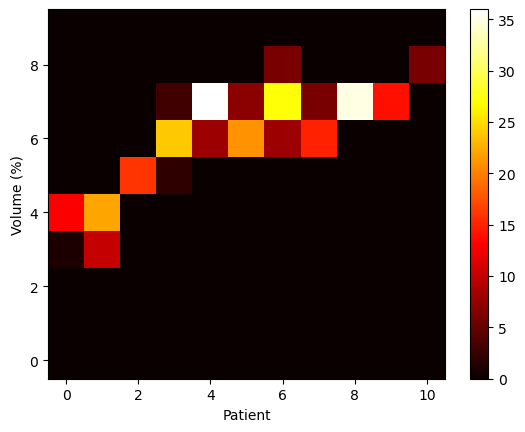

In [247]:
binning_volume = get_binning_volume(rand_train)

plt.imshow(binning_volume.T, cmap='hot', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Patient')
plt.ylabel('Volume (%)')
plt.show()

In [214]:
# binning_volume[1]

tensor([ 0.,  0.,  0., 10., 22.,  0.,  0.,  0.,  0.,  0.])

In [487]:
def create_boundingbox(dataset):
    boxes = []
    
    for idx, patient in enumerate(dataset):
#         if idx > 1:
#             break

    
        temp_list = [patient]
        heatmap = aggregate_heatmap(temp_list)
        
        height = heatmap.sum(dim= 1)
        
        h_min, h_max = 0, 0

        for i in range(height.shape[0]):
            if height[i] > 0:
                h_min = i
                break

        for i in range(height.shape[0] - 1, -1, -1):
            if height[i] > 0:
                h_max = i
                break

        width = heatmap.sum(dim= 0)

        w_min, w_max = 0, 0

        for i in range(width.shape[0]):
            if width[i] > 0:
                w_min = i
                break

        for i in range(width.shape[0] - 1, -1, -1):
            if width[i] > 0:
                w_max = i
                break
                
#         print(h_min, h_max, w_min, w_max)
        boxes.append([h_min, h_max, w_min, w_max])

    return boxes

In [489]:
boxes = create_boundingbox(train_dataset)
boxes

[[342, 412, 142, 199],
 [339, 419, 185, 256],
 [288, 340, 256, 323],
 [160, 188, 172, 204],
 [384, 397, 206, 224],
 [181, 238, 132, 215],
 [315, 350, 212, 282],
 [323, 374, 317, 358],
 [358, 379, 139, 166],
 [375, 409, 253, 282],
 [274, 346, 209, 284],
 [373, 398, 257, 277],
 [103, 171, 134, 192],
 [210, 324, 146, 181],
 [357, 381, 175, 205],
 [361, 389, 267, 291],
 [141, 193, 153, 195],
 [313, 351, 176, 212],
 [169, 188, 314, 336],
 [354, 395, 151, 196],
 [199, 226, 186, 212],
 [137, 174, 213, 259],
 [120, 196, 228, 333],
 [99, 128, 242, 272],
 [389, 404, 233, 247],
 [87, 123, 190, 241],
 [155, 208, 119, 178],
 [271, 359, 158, 242],
 [142, 178, 252, 287],
 [317, 343, 124, 147],
 [136, 185, 171, 205],
 [394, 417, 298, 318],
 [185, 218, 180, 222],
 [295, 394, 132, 211],
 [351, 382, 244, 284],
 [309, 354, 272, 310],
 [141, 163, 141, 160],
 [99, 174, 192, 272],
 [132, 154, 243, 265],
 [95, 170, 267, 371],
 [342, 356, 186, 203],
 [116, 188, 243, 298],
 [159, 237, 121, 221],
 [116, 195, 233

In [371]:
crt_investigation_idx = 49

a = train_dataset[crt_investigation_idx]['label'][0]


b = torch.nonzero(a.sum(axis=(0,1)))

start = b.min().item()
stop = b.max().item()

start, stop

(107, 112)

107


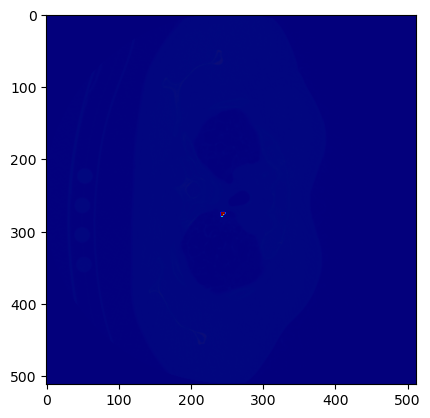

108


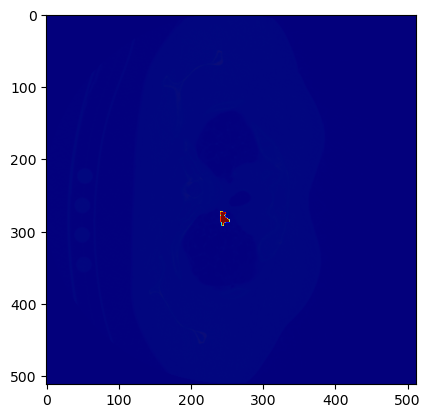

109


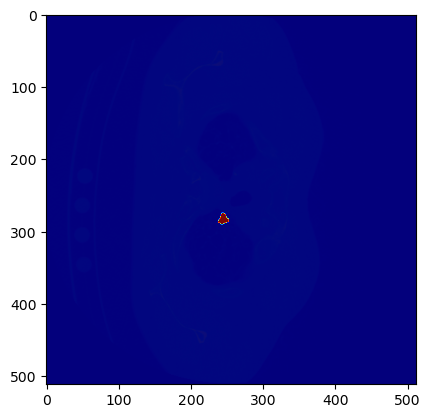

110


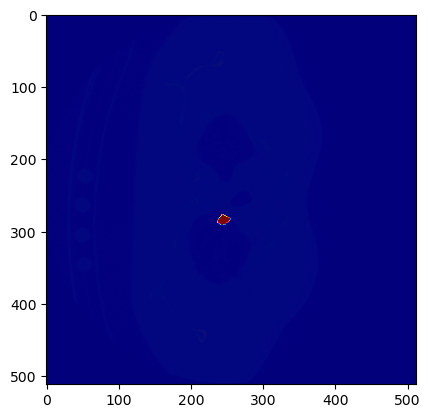

111


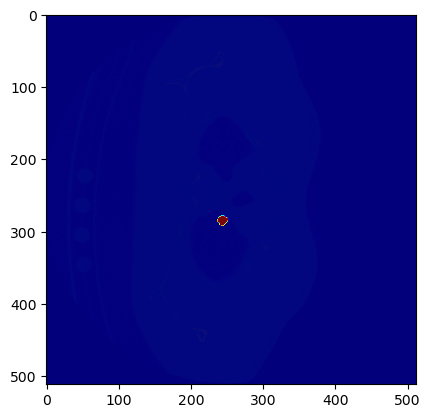

112


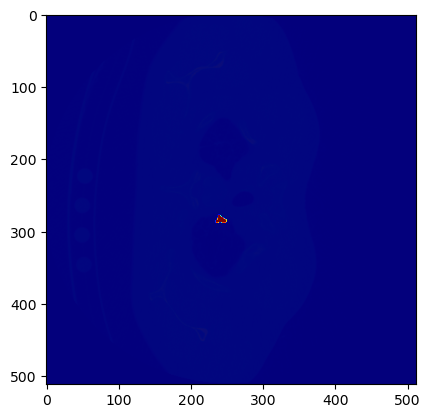

In [372]:
for i in range(start, stop+1):
    print(i)
    plt.imshow(train_dataset[crt_investigation_idx]['image'][0,..., i])
    plt.imshow(train_dataset[crt_investigation_idx]['label'][0,..., i] > 0, cmap = 'jet', alpha = 0.95)
    plt.show()

In [490]:
col_names = [['h_min', 'h_max', 'w_min', 'w_max']]

col_names += boxes    
# for area in areas:
#     data_dict['area'].append(area)
df = pd.DataFrame(data = col_names[1:], columns= col_names[0])

df['area'] = df.apply(lambda row: (row['h_max'] - row['h_min'] + 1) * (row['w_max'] - row['w_min'] + 1), axis=1)

df.describe()


,h_min,h_max,w_min,w_max,area
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,244.019608,290.529412,206.254902,252.549020,2766.627451
std,103.129722,99.791052,56.793254,56.438396,2683.163960
min,87.000000,123.000000,119.000000,147.000000,240.000000
25%,141.000000,188.000000,155.500000,205.000000,700.000000
50%,273.000000,340.000000,206.000000,256.000000,1786.000000
75%,342.000000,381.500000,249.500000,292.500000,4103.000000
max,394.000000,419.000000,322.000000,371.000000,11286.000000


In [491]:
def draw_bounding_boxes(boxes):
    plot_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'w']
    
    for box in boxes:
        h_min, h_max, w_min, w_max = box
        color = plot_colors[random.randint(0, len(plot_colors) - 1)]
        
        plt.plot([w_min, w_max], [h_min, h_min], color)
        plt.plot([w_min, w_max], [h_max, h_max], color)
        plt.plot([w_min, w_min], [h_min, h_max], color)
        plt.plot([w_max, w_max], [h_min, h_max], color)


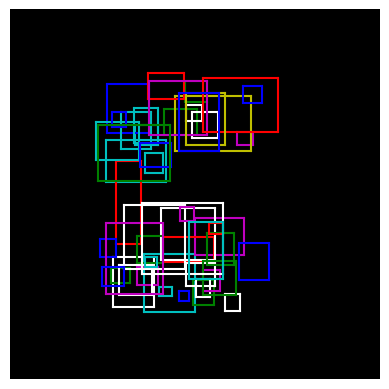

In [492]:
plt.imshow(train_dataset[0]['label'][0, ..., 1], cmap='gray')
draw_bounding_boxes(boxes)
plt.axis('off')
plt.show()